# **Projet Télédétection Landes - Marion BILLY**

## I - Introduction

Ce projet vise à caractériser la phénologie de différentes strates de végétation (herbacée, landes, arborée) en Bretagne à partir d’une série temporelle Sentinel-2 acquise entre mars et août 2025. Une attention particulière est portée à la signature spectrale des landes afin de les distinguer des autres types de végétation.

  **Série Sentinel-2 :** Mars à Août 2025 en Bretagne
| Date       | Fichier créé                        |
|------------|------------------------------------|
| 2025-03-31 | bretagne_2025-03-31.tif            |
| 2025-04-10 | bretagne_2025-04-10.tif            |
| 2025-05-15 | bretagne_2025-05-15.tif            |
| 2025-06-17 | bretagne_2025-06-17.tif            |
| 2025-07-12 | bretagne_2025-07-12.tif            |
| 2025-08-10 | bretagne_2025-08-10.tif            |

**Échantillon :** `PI_strates_bretagne.shp`  
**Classes :** 1 Sol Nu, 2 Herbe, 3 Landes, 4 Arbre


In [1]:
# import des librairies
import sys
sys.path.append("/home/onyxia/work")
import os
from osgeo import gdal
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

# personal librairies
from libsigma import read_and_write as rw
from libsigma import classification as cla

Extraction des séries temporelles par bande Sentinel, chaque bande d’un fichier correspondant à une date (même ordre que ci-dessus)

Les images Sentinel-2 sont initialement fournies sous forme de séries temporelles par bande. Afin de faciliter les analyses ultérieures, les bandes ont été regroupées par date pour produire une image multibande Sentinel-2 par date.

In [2]:
base_path = "/home/onyxia/work/data/projet_eval/"
bands = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
dates = ["2025-03-31","2025-04-10","2025-05-15","2025-06-17","2025-07-12","2025-08-10"]

for i, date in enumerate(dates):
    band_arrays = []
    for band in bands:
        filename = os.path.join(base_path, f"bretagne_24-25_{band}.tif")
        arr = rw.load_img_as_array(filename)  # shape = (lignes, colonnes, nb_dates)
        # extraire la bande correspondant à la date i
        single_band = arr[:, :, i]
        # s'assurer que c'est 3D pour write_image
        band_arrays.append(np.atleast_3d(single_band))
    
    # concaténer toutes les bandes pour cette date
    all_bands = np.dstack(band_arrays)  # shape = (lignes, colonnes, nb_bandes)
    
    out_filename = os.path.join(base_path, f"bretagne_{date}.tif")
    rw.write_image(out_filename, all_bands, data_set=rw.open_image(os.path.join(base_path, f"bretagne_24-25_{bands[0]}.tif")))
    print(f"Fichier créé pour {date} -> {out_filename}")

/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Fichier créé pour 2025-03-31 -> /home/onyxia/work/data/projet_eval/bretagne_2025-03-31.tif
Fichier créé pour 2025-04-10 -> /home/onyxia/work/data/projet_eval/bretagne_2025-04-10.tif
Fichier créé pour 2025-05-15 -> /home/onyxia/work/data/projet_eval/bretagne_2025-05-15.tif
Fichier créé pour 2025-06-17 -> /home/onyxia/work/data/projet_eval/bretagne_2025-06-17.tif
Fichier créé pour 2025-07-12 -> /home/onyxia/work/data/projet_eval/bretagne_2025-07-12.tif
Fichier créé pour 2025-08-10 -> /home/onyxia/work/data/projet_eval/bretagne_2025-08-10.tif


## II - Analyse des échantillons

### 1. Nombre d'échantillons

In [3]:
gdf = gpd.read_file("/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp")
gdf.head()

,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((441224.58 5366298.317, 441224.779 53..."
1,2,3,lande basse,"POLYGON ((441649.972 5366251.139, 441650.172 5..."
2,3,3,lande basse,"POLYGON ((441383.597 5366193.034, 441384.395 5..."
3,4,2,None,"POLYGON ((441336.658 5366402.088, 441337.257 5..."
4,5,2,None,"POLYGON ((441062.121 5366343.165, 441062.919 5..."


#### Diagramme en bâton du nombre de polygones par classe, diag_baton_nb_poly_by_class.png

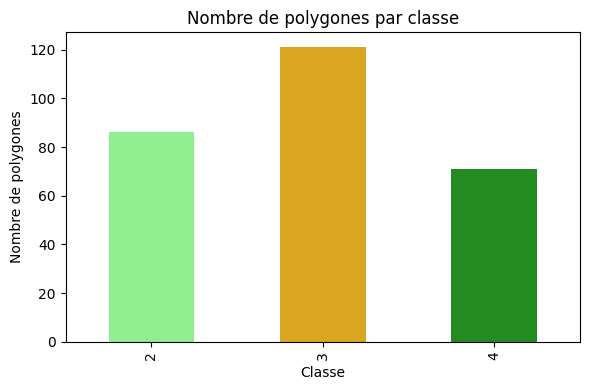

In [4]:
nb_poly = gdf["strate"].value_counts().sort_index()
plt.figure(figsize=(6,4))
colors = ["lightgreen", "goldenrod", "forestgreen"]
nb_poly.plot(kind="bar", color=colors)
plt.xlabel("Classe")
plt.ylabel("Nombre de polygones")
plt.title("Nombre de polygones par classe")
plt.tight_layout()
plt.savefig("/home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png", dpi=300)
plt.show()

#### Diagramme en bâton du nombre de pixel par classe, diag_baton_nb_pix_by_class.png

Créer une image d’échantillons en rasterisant le fichier vecteur. L’image créée aura les mêmes dimensions que l’image qu’on cherche à classer ainsi que la même taille de pixel. Une fois cette image obtenue, il est facile d’extraire les valeurs des pixels de l’image qui correspondent aux échantillons à l’aide de Numpy.

Les paramètres spatiaux (résolution et emprise) sont extraits de l’image Sentinel-2 de référence afin de garantir une parfaite correspondance spatiale entre l’image d’échantillons rasterisée et les images utilisées pour la classification.

In [52]:
my_folder = '/home/onyxia/work/data/projet_eval'
ref_image = os.path.join(my_folder, 'bretagne_2025-03-31.tif') # une image Sentinel-2 de référence

# ouverture de l'image
data_set = rw.open_image(ref_image)

# informations de l'image
nb_lignes, nb_col, _ = rw.get_image_dimension(data_set)
origin_x, origin_y = rw.get_origin_coordinates(data_set)
psize_x, psize_y = rw.get_pixel_size(data_set)
sptial_resolution = abs(psize_x)

# emprise spatiale
xmin = origin_x
xmax = origin_x + nb_col * psize_x
ymax = origin_y
ymin = origin_y + nb_lignes * psize_y

# affichage des paramètres
print("Spatial resolution :", sptial_resolution)
print("Extent :")
print("xmin =", xmin, "ymin =", ymin)
print("xmax =", xmax, "ymax =", ymax)

Spatial resolution : 10.0
Extent :
xmin = 432950.0 ymin = 5362770.0
xmax = 448280.0 ymax = 5368890.0


In [53]:
# define parameters
my_folder = '/home/onyxia/work/data/projet_eval'
in_vector = os.path.join(my_folder, 'PI_strates_bretagne_32630.shp')
ref_image = os.path.join(my_folder, 'bretagne_2025-03-31.tif') # une image Sentinel-2 de référence
out_image = os.path.splitext(in_vector)[0] + '_v2.tif'
field_name = 'strate'  # field containing the numeric label of the classes

# define command pattern to fill with paremeters
cmd_pattern = ("gdal_rasterize -a {field_name} "
               "-tr {sptial_resolution} {sptial_resolution} "
               "-te {xmin} {ymin} {xmax} {ymax} -ot Byte -of GTiff "
               "{in_vector} {out_image}")

# fill the string with the parameter thanks to format function
cmd = cmd_pattern.format(in_vector=in_vector, xmin=xmin, ymin=ymin, xmax=xmax,
                         ymax=ymax, out_image=out_image, field_name=field_name,
                         sptial_resolution=sptial_resolution)

# execute the command in the terminal
os.system(cmd)

0...10...20...30...40...50...60...70...80...90...100 - done.


0

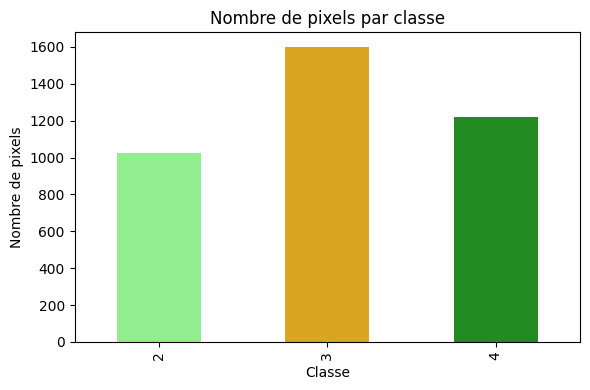

In [54]:
roi_raster = os.path.join(my_folder, 'PI_strates_bretagne_32630_v2.tif')

# get_samples_from_roi renvoie X (valeurs des pixels), Y (labels), t (coordonnées)
_, Y, _ = cla.get_samples_from_roi(roi_raster, roi_raster)

# compter le nombre de pixels par classe
classes, counts = np.unique(Y, return_counts=True)
pixel_counts = dict(zip(classes, counts))

# tri par classe
pixel_series = pd.Series(pixel_counts).sort_index()

# Diagramme
plt.figure(figsize=(6,4))
colors = ["lightgreen", "goldenrod", "forestgreen"]
pixel_series.plot(kind="bar", color=colors)
plt.xlabel("Classe")
plt.ylabel("Nombre de pixels")
plt.title("Nombre de pixels par classe")
plt.tight_layout()
plt.savefig("/home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.png", dpi=300)
plt.show()

stocker les plots et les afficher côte à côte seulement après

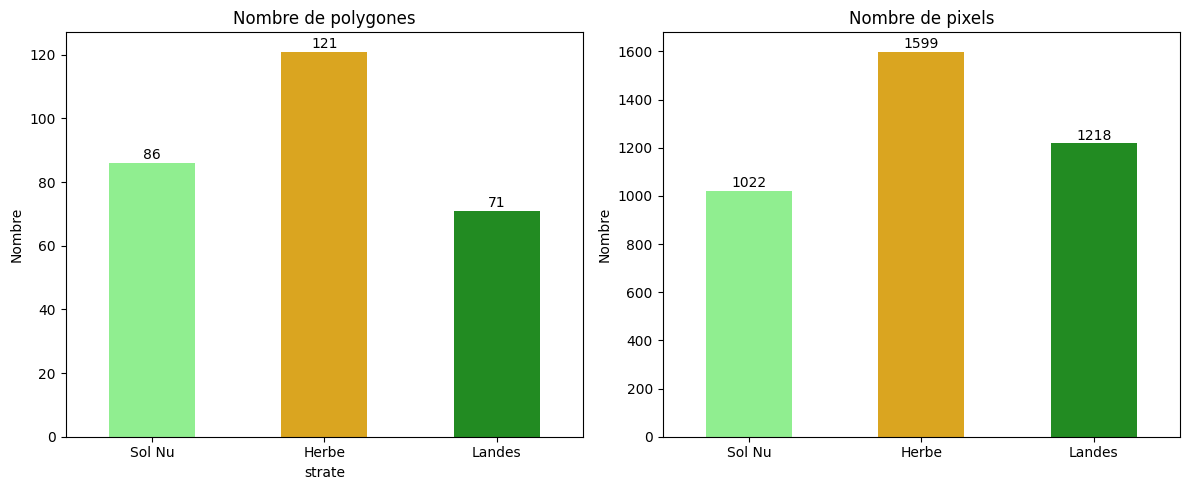

,Classe,Polygones,Pixels
0,Sol Nu,0,0
1,Herbe,86,1022
2,Landes,121,1599
3,Arbre,71,1218


In [ ]:
# --- Couleurs et labels ---
colors = ["lightgreen", "goldenrod", "forestgreen", "darkgreen"]
class_labels = ["Sol Nu", "Herbe", "Landes", "Arbre"]

# --- Comptage des polygones ---
nb_poly = gdf["strate"].value_counts().sort_index()

# --- Comptage des pixels ---
_, Y, _ = cla.get_samples_from_roi(roi_raster, roi_raster)
pixel_counts = dict(zip(*np.unique(Y, return_counts=True)))
pixel_series = pd.Series(pixel_counts).sort_index()

# --- Figure côte à côte ---
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Polygones
nb_poly.plot(kind="bar", color=colors, ax=axes[0])
present_labels = [class_labels[i-2] for i in nb_poly.index]  # ici, index = 2,3,4
axes[0].set_xticklabels(present_labels, rotation=0)
axes[0].set_title("Nombre de polygones")
axes[0].set_ylabel("Nombre")
for i, v in enumerate(nb_poly):
    axes[0].text(i, v + max(nb_poly)*0.01, str(v), ha='center')

# Pixels
pixel_series.plot(kind="bar", color=colors, ax=axes[1])
present_labels_pix = [class_labels[i-2] for i in pixel_series.index]
axes[1].set_xticklabels(present_labels_pix, rotation=0)
axes[1].set_title("Nombre de pixels")
axes[1].set_ylabel("Nombre")
for i, v in enumerate(pixel_series):
    axes[1].text(i, v + max(pixel_series)*0.01, str(v), ha='center')

plt.tight_layout()
plt.show()

# --- Tableau récapitulatif ---
all_classes = [1, 2, 3, 4]
nb_poly_all = nb_poly.reindex(all_classes, fill_value=0)
pixel_series_all = pixel_series.reindex(all_classes, fill_value=0)

df_summary = pd.DataFrame({
    "Classe": class_labels,  # tous les labels
    "Polygones": nb_poly_all.values,
    "Pixels": pixel_series_all.values
})
df_summary

### 2. Phénologie des strates, mise en évidence des landes

Reconnaître les signatures spectrales et leur évolution temporelle.

On a la liste des images multibandes par date. (B03 → index 1, B05 → index 3)

Calcul ARI

L’ARI (Anthocyanin Reflectance Index) est utilisé ici comme indicateur de stress ou de sénescence végétale, permettant de mettre en évidence des différences phénologiques entre strates au cours de la saison de croissance.

In [8]:
# dossier de travail
data_dir = "/home/onyxia/work/data/projet_eval"
out_dir = "/home/onyxia/work/results"

dates = [
    "2025-03-31",
    "2025-04-10",
    "2025-05-15",
    "2025-06-17",
    "2025-07-12",
    "2025-08-10"
]

ari_list = []

for date in dates:
    filename = os.path.join(data_dir, f"bretagne_{date}.tif")

    # ouverture
    data_set = rw.open_image(filename)
    img = rw.load_img_as_array(filename)

    # bandes nécessaires
    b03 = img[:, :, 1].astype("float32")
    b05 = img[:, :, 3].astype("float32")

    # masque pixels valides, éviter divisions par zéro
    mask_valid = (b03 > 0) & (b05 > 0)

    # tableau ARI initialisé avec NoData
    ari = np.full(b03.shape, -9999, dtype="float32")

    # calcul ARI uniquement sur pixels valides
    ari[mask_valid] = (
        (1.0 / b03[mask_valid] - 1.0 / b05[mask_valid]) /
        (1.0 / b03[mask_valid] + 1.0 / b05[mask_valid])
    )

    # ajout à la liste pour empilement temporel
    ari_list.append(ari[:, :, np.newaxis])


Empilement temporel

In [9]:
ari_serie_temp = np.concatenate(ari_list, axis=2)

out_filename = os.path.join(out_dir, "ARI_serie_temp.tif")

rw.write_image(
    out_filename,
    ari_serie_temp,
    data_set=data_set,
    gdal_dtype=gdal.GDT_Float32,
)

Graphique série temporelle, moyenne et écarts types

In [10]:

# get_samples_from_roi renvoie X (valeurs ARI), Y (labels), t (coordonnées)
X_samples, Y_samples, _ = cla.get_samples_from_roi("/home/onyxia/work/results/ARI_serie_temp.tif", roi_raster)

# X_samples : valeurs ARI pour les pixels d'échantillons (n_pixels, n_dates)
# Y_samples : labels des strates correspondants (n_pixels,)

# convertir en DataFrame
df = pd.DataFrame(X_samples, columns=dates)
df['strate'] = Y_samples.flatten()

# remplacer NoData par NaN
df.replace(-9999, np.nan, inplace=True)

# moyenne et écart-type par strate
grouped = df.groupby('strate')
mean_df = grouped.mean()
std_df = grouped.std()



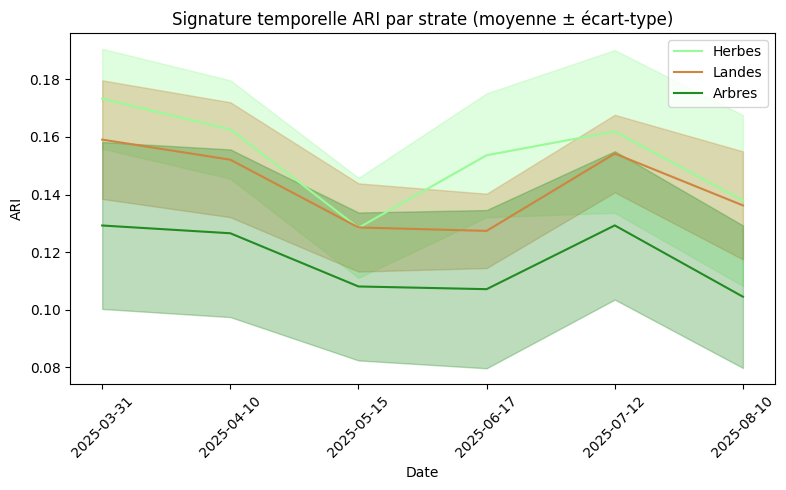

In [11]:
# couleurs et labels pour les strates
colors = {2: 'palegreen', 3: 'peru', 4: 'forestgreen'}
labels_name = {2: 'Herbes', 3: 'Landes', 4: 'Arbres'}

fig, ax = plt.subplots(figsize=(8,5))

for strate in mean_df.index:
    means = mean_df.loc[strate].values
    stds = std_df.loc[strate].values
    ax.plot(range(len(dates)), means, color=colors[strate], label=labels_name[strate])
    ax.fill_between(
        range(len(dates)),
        means - stds,
        means + stds,
        color=colors[strate],
        alpha=0.3
    )

ax.set_xticks(range(len(dates)))
ax.set_xticklabels(dates, rotation=45)
ax.set_xlabel("Date")
ax.set_ylabel("ARI")
ax.set_title("Signature temporelle ARI par strate (moyenne ± écart-type)")
ax.legend()
plt.tight_layout()

fig_dir = os.path.join(out_dir, "figure")
os.makedirs(fig_dir, exist_ok=True)
plt.savefig(os.path.join(fig_dir, "ARI_signature_by_strate.png"), dpi=300)
plt.show()




Si la courbe des landesest distincte dans le temps des autres strates, surtout à certaines dates (ex. pic automnal dû aux anthocyanes), alors on peut dire que le ARI permet de distinguer la lande.

Sinon, elle se confond avec d’autres classes et ARI seul ne suffit pas.

## III - Production d’une carte de strates à l’échelle du pixel

Produire une carte spatiale des strates de végétation (Sol nu / Herbe / Landes / Arbres) à partir des images Sentinel-2, puis évaluer la qualité de la classification à l’aide des échantillons terrain.

Préparer les données pour la classification

In [13]:
# Liste de toutes les images multibandes par date
stack_list = []

for date in dates:
    img_file = os.path.join(data_dir, f"bretagne_{date}.tif")
    img = rw.load_img_as_array(img_file)  # shape = lignes x colonnes x nb_bandes
    stack_list.append(img)

# Ajouter ARI
ari_file = os.path.join(out_dir, "ARI_serie_temp.tif")
ari_img = rw.load_img_as_array(ari_file)  # shape = lignes x colonnes x n_dates
stack_list.append(ari_img)

# Concaténation sur la 3e dimension (toutes les variables)
full_stack = np.dstack(stack_list)  # shape = lignes x colonnes x n_variables
print("Full stack shape:", full_stack.shape)

Full stack shape: (612, 1533, 66)


### 1. Choix du classifieur et sa paramètrisation

Pour la classification supervisée des strates, nous avons choisi le classifieur RandomForestClassifier de la bibliothèque scikit-learn.
Cette méthode repose sur l’assemblage de multiples arbres de décision et permet de limiter le sur-apprentissage tout en conservant une grande capacité d’apprentissage.
Les variables explicatives utilisées correspondent à l’empilement temporel des bandes Sentinel-2 ainsi que des indices ARI calculés pour chaque date.
L’optimisation des hyperparamètres du classifieur a été réalisée via une recherche sur grille (GridSearchCV) afin d’identifier la combinaison qui maximise la capacité du modèle à généraliser aux données non vues.

Extraire X et Y pour les pixels d’échantillon

In [20]:
full_stack_file = os.path.join(out_dir, "full_stack.tif")
rw.write_image(full_stack_file, full_stack, data_set=data_set)  # data_set = Sentinel de référence

# Extraire X et Y depuis le fichier raster
X, Y, _ = cla.get_samples_from_roi(full_stack_file, roi_raster)

# Remplacer NoData si nécessaire
X = np.nan_to_num(X, nan=-9999)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

Y = Y.ravel()  # transforme (3839,1) → (3839,)

X shape: (3839, 66)
Y shape: (3839, 1)


Split train/test et validation croisée

Optimisation des hyperparamètres avec RF

On utilise stratify=Y dans le split pour préserver la proportion des classes.

f1_weighted prend en compte le déséquilibre de classes.

Après GridSearch, tu peux examiner l’importance des variables via best_model.feature_importances_ pour voir quelles bandes ou dates sont les plus discriminantes.

Évaluer le modèle final sur le jeu de test

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

# Définir la grille des hyperparamètres à tester
param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [10, 15, 20, None],
    "max_features": ["sqrt", "log2", None],
    "min_samples_leaf": [1, 5]
}

# Créer le classifieur RF
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV avec validation croisée à 5 plis et métrique F1 pondérée
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring="f1_weighted",# métrique adaptée aux classes déséquilibrées
    n_jobs=-1
    return_train_score=True
)

# Lancer l’optimisation
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10, ...], 'max_features': [None, 'sqrt', ...], 'min_samples_leaf': [1, 5], 'n_estimators': [50, 100, ...]}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


### 2. Stratégie de validation

In [64]:
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

# Récupérer le meilleur modèle
best_model = grid_search.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleure F1-weighted CV :", grid_search.best_score_)
print(f"F1 CV moyen : {grid_search.best_score_:.3f}")

# Écart-type des scores CV
cv_results = pd.DataFrame(grid_search.cv_results_)
best_index = grid_search.best_index_
print(f"Écart-type CV du meilleur modèle : {cv_results.loc[best_index,'std_test_score']:.3f}")

# Évaluation sur le jeu de test
y_pred = best_model.predict(X_test)
print("Classification report sur test set :")
print(classification_report(y_test, y_pred))
# Compute the quality metrics by classe.
report_str = classification_report(y_test, y_pred, labels=np.unique(y_test))#, output_dict=True)

cm = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(cm)
print(type(cm))

# Compute the overall accuracy
accuracy = accuracy_score(y_test, y_pred)
f1_test = f1_score(y_test, y_pred, average='weighted')
print(f"Accuracy test : {accuracy:.3f}")
print(f"F1 test : {f1_test:.3f}")
print("\nRapport de classification :\n", classification_report(y_test, y_pred, target_names=strates))


Meilleurs hyperparamètres : {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 300}
Meilleure F1-weighted CV : 0.9721517119827393
F1 CV moyen : 0.972
Écart-type CV du meilleur modèle : 0.006
Classification report sur test set :
              precision    recall  f1-score   support

           2       1.00      0.98      0.99       307
           3       0.97      0.98      0.98       480
           4       0.98      0.97      0.97       365

    accuracy                           0.98      1152
   macro avg       0.98      0.98      0.98      1152
weighted avg       0.98      0.98      0.98      1152

Matrice de confusion :
[[301   6   0]
 [  0 471   9]
 [  1   9 355]]
<class 'numpy.ndarray'>
Accuracy test : 0.978
F1 test : 0.978


NameError: name 'strates' is not defined

In [50]:
# Récupérer les résultats complets de GridSearchCV
cv_results = grid_search.cv_results_
# Créer un DataFrame avec uniquement les colonnes utiles
df_results = pd.DataFrame({
    'n_estimators': cv_results['param_n_estimators'],
    'max_depth': cv_results['param_max_depth'],
    'max_features': cv_results.get('param_max_features', None),  # si tu as ce paramètre
    'min_samples_leaf': cv_results.get('param_min_samples_leaf', None),
    'mean_test_score': cv_results['mean_test_score'],
    'std_test_score': cv_results['std_test_score'],
    'rank_test_score': cv_results['rank_test_score']
})
# Afficher les 10 meilleures combinaisons
df_results.sort_values('rank_test_score').head(10)

,n_estimators,max_depth,max_features,min_samples_leaf,mean_test_score,std_test_score,rank_test_score
24,300,None,log2,1,0.972152,0.006299,1
114,300,20,log2,1,0.972152,0.006299,1
84,300,15,log2,1,0.971781,0.006342,3
81,100,15,log2,1,0.971766,0.006863,4
111,100,20,log2,1,0.971014,0.005920,5
21,100,None,log2,1,0.971014,0.005920,5
83,200,15,log2,1,0.970657,0.005664,7
23,200,None,log2,1,0.970281,0.005627,8
113,200,20,log2,1,0.970281,0.005627,8
112,150,20,log2,1,0.969532,0.005074,10


Matrice de confusion

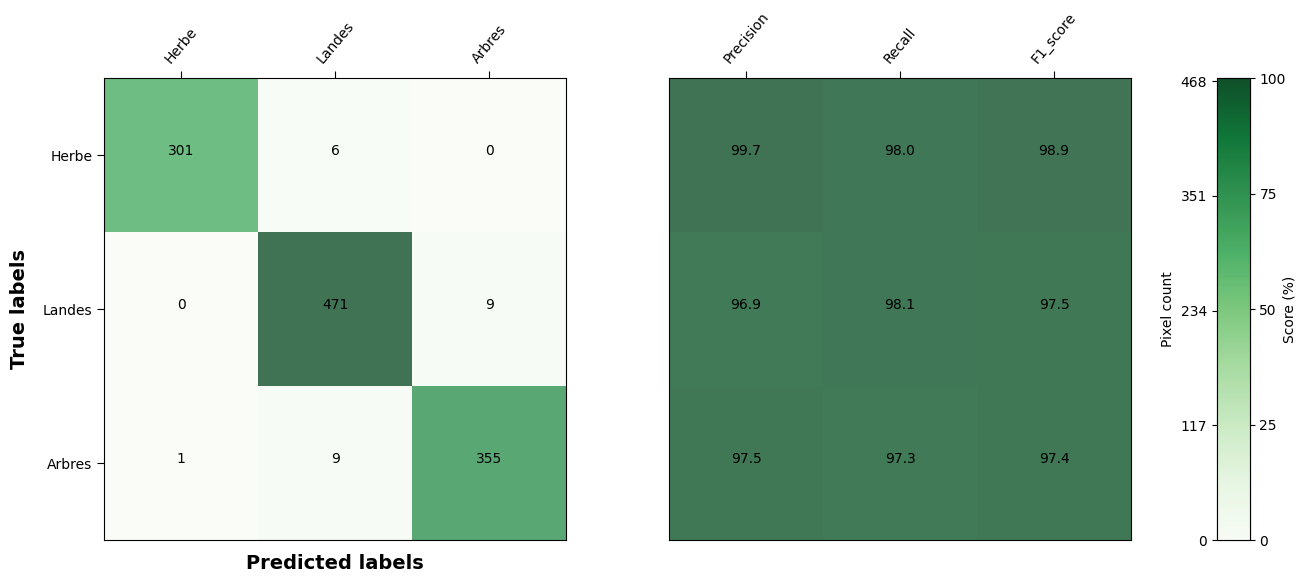

In [71]:
from libsigma import plots

plots.plot_cm(cm, labels=['Herbe', 'Landes', 'Arbres'])

Qualité des classes

In [79]:
report = classification_report(y_test, y_pred, labels=np.unique(y_test), output_dict=True)
# Affiche tout le dictionnaire
print(report)
print()

report_df = pd.DataFrame.from_dict(report)
report_df

# keep columns
report_df = report_df.loc[:, ['2', '3', '4']]
# drop rows (axis=0, same as numpy)
report_df = report_df.drop(['support'], axis=0)
report_df

{'2': {'precision': 0.9966887417218543, 'recall': 0.9804560260586319, 'f1-score': 0.9885057471264368, 'support': 307.0}, '3': {'precision': 0.9691358024691358, 'recall': 0.98125, 'f1-score': 0.9751552795031055, 'support': 480.0}, '4': {'precision': 0.9752747252747253, 'recall': 0.9726027397260274, 'f1-score': 0.9739368998628258, 'support': 365.0}, 'accuracy': 0.9782986111111112, 'macro avg': {'precision': 0.9803664231552385, 'recall': 0.9781029219282198, 'f1-score': 0.9791993088307893, 'support': 1152.0}, 'weighted avg': {'precision': 0.9784235274471086, 'recall': 0.9782986111111112, 'f1-score': 0.9783270546694776, 'support': 1152.0}}



,2,3,4
precision,0.996689,0.969136,0.975275
recall,0.980456,0.981250,0.972603
f1-score,0.988506,0.975155,0.973937


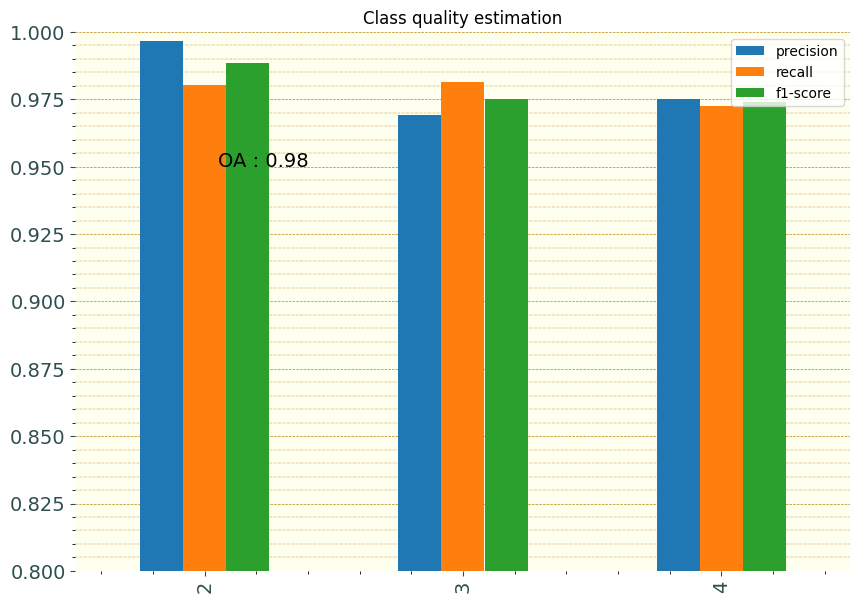

In [84]:
fig, ax = plt.subplots(figsize=(10,7))
ax = report_df.T.plot.bar(ax=ax, zorder=2)

# custom : information
ax.set_ylim(0.8, 1)
ax.text(0.05, 0.95, 'OA : {:.2f}'.format(accuracy), fontsize=14)
ax.set_title('Class quality estimation')

# custom : cuteness
# background color
ax.set_facecolor('ivory')
# labels
x_label = ax.get_xlabel()
ax.set_xlabel(x_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
y_label = ax.get_ylabel()
ax.set_ylabel(y_label, fontdict={'fontname': 'Sawasdee'}, fontsize=14)
# borders
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='x', colors='darkslategrey', labelsize=14)
ax.tick_params(axis='y', colors='darkslategrey', labelsize=14)
# grid
ax.minorticks_on()
ax.yaxis.grid(which='major', color='darkgoldenrod', linestyle='--',
                      linewidth=0.5, zorder=1)
ax.yaxis.grid(which='minor', color='darkgoldenrod', linestyle='-.',
                      linewidth=0.3, zorder=1)

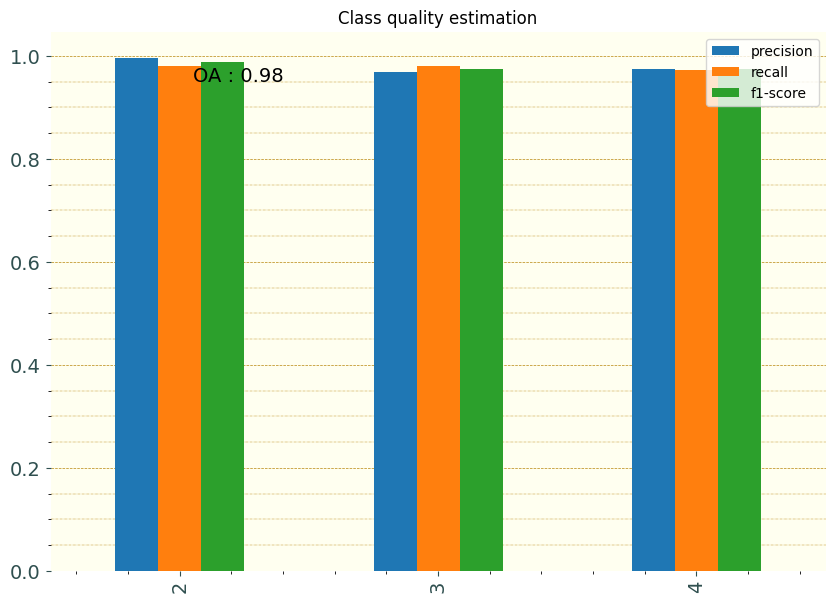

In [87]:
plots.plot_class_quality(report, accuracy) #out_filename=out_qualite

### 3. Contribution des variables

In [38]:
# Contribution des variables
contributions = best_model.feature_importances_

# Noms des variables : toutes les bandes pour chaque date + ARI
band_names = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
ari_dates = dates
features = [f"{band}_{date}" for date in dates for band in band_names] + [f"ARI_{date}" for date in dates]

# dataframe
df_contributions = pd.DataFrame({
    "feature": features,
    "contribution": contributions
})

# trier par contribution
df_contributions.sort_values("contribution", ascending=False, inplace=True)

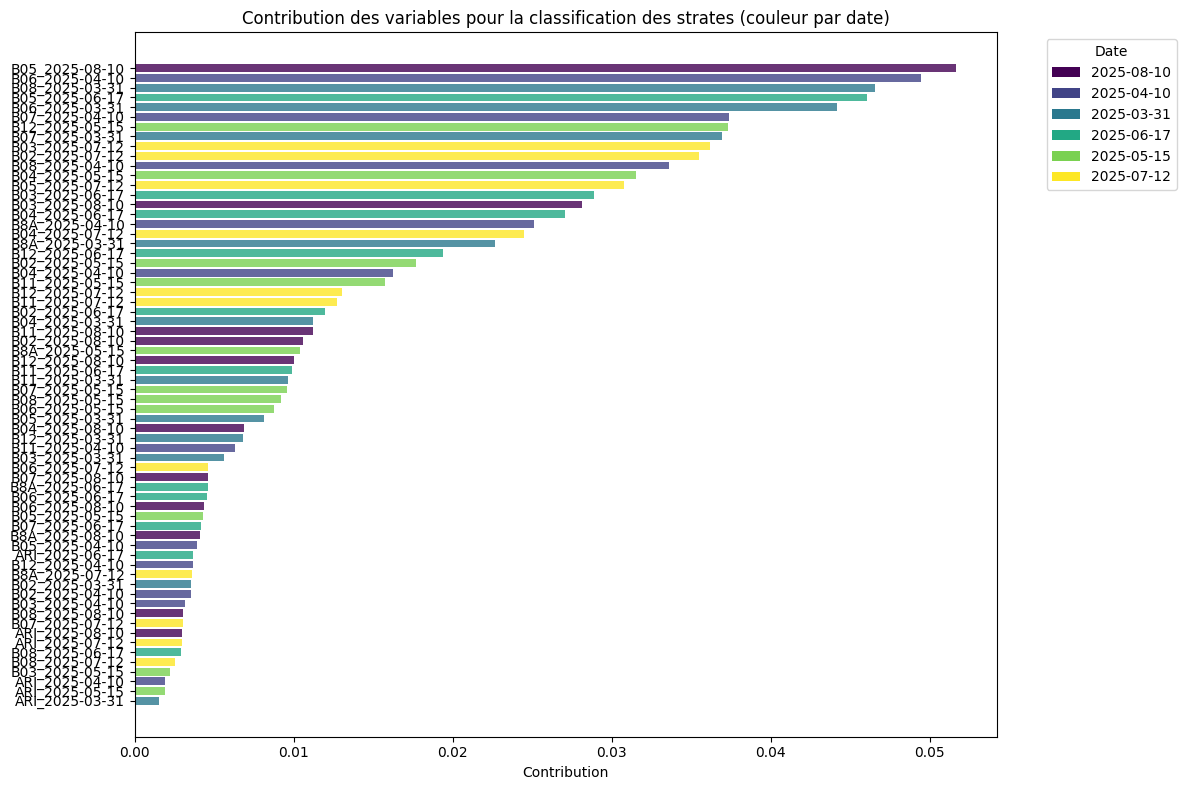

In [39]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# extraire la date depuis le nom des features
df_contributions["date"] = df_contributions["feature"].apply(lambda x: x.split("_")[1])

# créer une palette de couleurs pour les dates
unique_dates = df_contributions["date"].unique()
colors = cm.viridis(np.linspace(0, 1, len(unique_dates)))  # tu peux changer "viridis" par "tab10", "plasma", etc.
date_color_map = dict(zip(unique_dates, colors))

# couleur pour chaque barre
bar_colors = df_contributions["date"].map(date_color_map)

plt.figure(figsize=(12,8))
plt.barh(
    df_contributions["feature"], 
    df_contributions["contribution"], 
    color=df_contributions["date"].map(date_color_map), 
    alpha=0.8
)
plt.xlabel("Contribution")
plt.title("Contribution des variables pour la classification des strates (couleur par date)")
plt.gca().invert_yaxis()

# légende
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=date_color_map[d], label=d) for d in unique_dates]
plt.legend(handles=legend_elements, title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


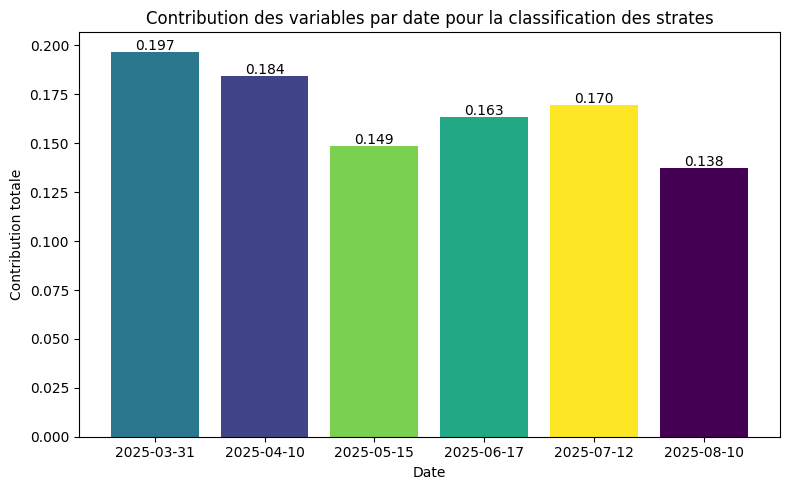

In [40]:
plt.figure(figsize=(8,5))
plt.bar(
    contrib_par_date.index, 
    contrib_par_date.values, 
    color=[date_color_map[d] for d in contrib_par_date.index]
)
plt.ylabel("Contribution totale")
plt.xlabel("Date")
plt.title("Contribution des variables par date pour la classification des strates")

# ajouter les valeurs
for i, v in enumerate(contrib_par_date.values):
    plt.text(i, v + 0.001, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

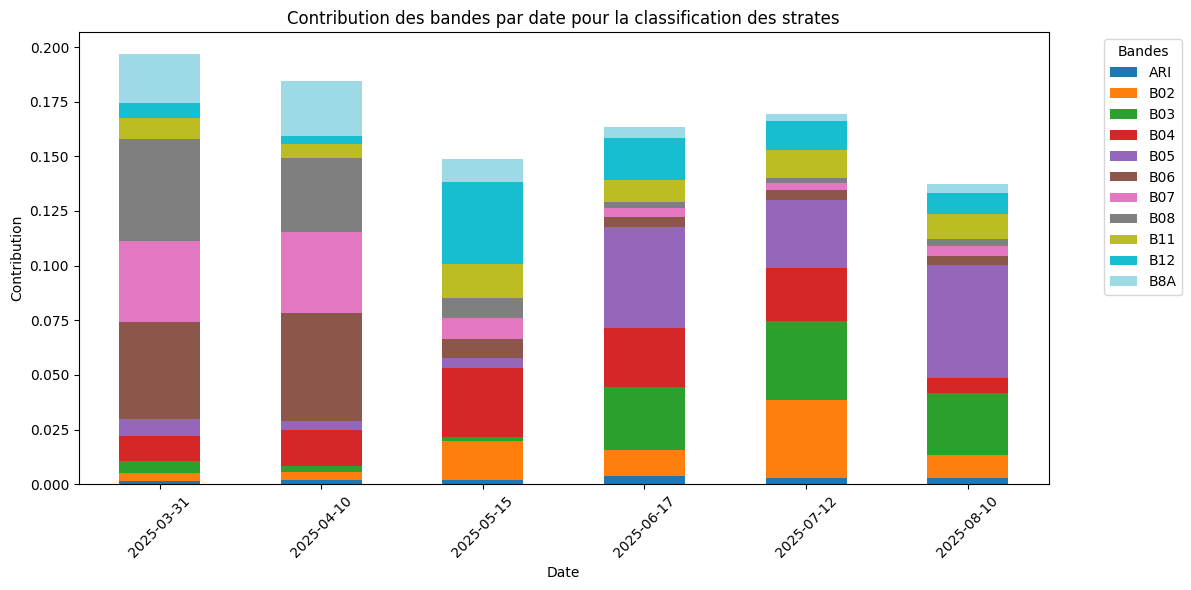

In [ ]:
pivot_df = df_contributions.pivot_table(index="date", columns="band", values="contribution", aggfunc="sum")
pivot_df.plot(
    kind="bar", 
    stacked=True, 
    figsize=(12,6), 
    colormap="tab20"  # couleurs différentes pour chaque bande
)
plt.ylabel("Contribution")
plt.xlabel("Date")
plt.title("Contribution des bandes par date pour la classification des strates")
plt.xticks(rotation=45)
plt.legend(title="Bandes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 4. Production des cartes finales

In [41]:
# -----------------------------
# 1. Charger les données empilées
# -----------------------------
full_stack_file = os.path.join(out_dir, "full_stack.tif")
img_stack = rw.load_img_as_array(full_stack_file)  # shape: lignes x colonnes x n_features

# récupérer dimensions
n_rows, n_cols, n_features = img_stack.shape

# -----------------------------
# 2. Préparer les données pour la prédiction
# -----------------------------
X_pred = img_stack.reshape(-1, n_features)  # transformer en n_pixels x n_features
X_pred = np.nan_to_num(X_pred, nan=-9999)   # remplacer les NoData si nécessaire

# -----------------------------
# 3. Prédire avec le modèle optimisé
# -----------------------------
y_pred_flat = best_model.predict(X_pred)

# -----------------------------
# 4. Reshape pour revenir à la taille d'origine
# -----------------------------
y_pred_raster = y_pred_flat.reshape(n_rows, n_cols)

# -----------------------------
# 5. Fixer le NoData et type uint8
# -----------------------------
y_pred_raster = y_pred_raster.astype(np.uint8)
y_pred_raster[y_pred_raster == 0] = 0  # nodata = 0

# -----------------------------
# 6. Sauvegarder la carte finale
# -----------------------------
carte_file = os.path.join(out_dir, "carte_strates.tif")
rw.write_image(
    carte_file,
    y_pred_raster,
    data_set=rw.open_image(full_stack_file),
    gdal_dtype=gdal.GDT_Byte
)

print("Carte des strates produite :", carte_file)

Carte des strates produite : /home/onyxia/work/results/carte_strates.tif


### 5. Analyse des résultats

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# extraire X et Y pour les échantillons
X_test_samples, Y_test_samples, _ = cla.get_samples_from_roi(full_stack_file, roi_raster)
X_test_samples = np.nan_to_num(X_test_samples, nan=-9999)
Y_test_samples = Y_test_samples.ravel()

# prédiction sur les échantillons
Y_pred_samples = best_model.predict(X_test_samples)

# rapport
print(classification_report(Y_test_samples, Y_pred_samples))
print(confusion_matrix(Y_test_samples, Y_pred_samples))

              precision    recall  f1-score   support

           2       1.00      0.99      1.00      1022
           3       0.99      0.99      0.99      1599
           4       0.99      0.99      0.99      1218

    accuracy                           0.99      3839
   macro avg       0.99      0.99      0.99      3839
weighted avg       0.99      0.99      0.99      3839

[[1016    6    0]
 [   0 1590    9]
 [   1    9 1208]]


In [ ]:
# créer une carte d'erreur binaire : 1 = correct, 0 = erreur
error_map = np.zeros_like(y_pred_raster, dtype=np.uint8)

# transformer les coordonnées des échantillons en indices raster
# ici on suppose cla.get_samples_from_roi fournit les indices correspondant
# sinon, simplification : visualiser uniquement le raster
# problème car la légende affiche des valeurs continues alors qu'il n'y a que 3 valeurs discrètes, 2 3 4

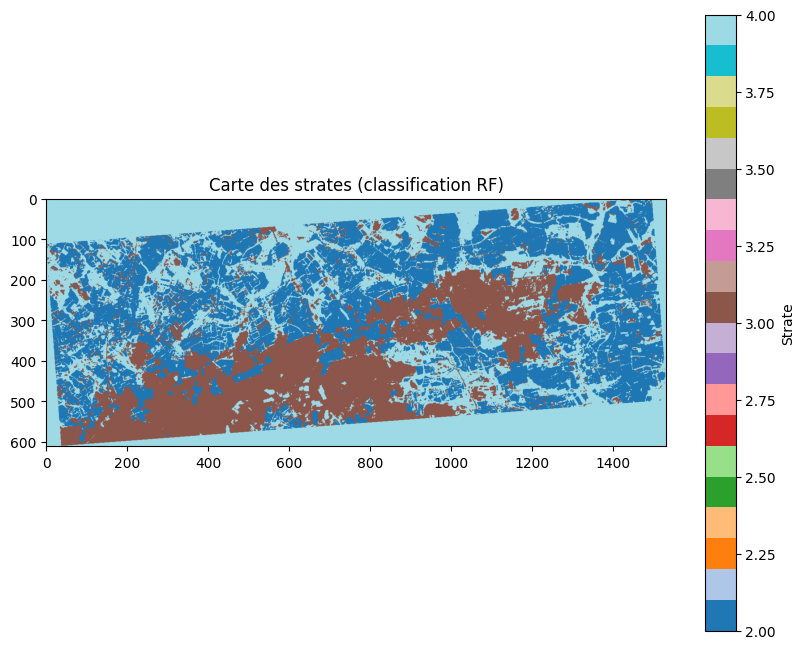

In [44]:
plt.figure(figsize=(10,8))
plt.imshow(y_pred_raster, cmap='tab20')
plt.colorbar(label='Strate')
plt.title("Carte des strates (classification RF)")
plt.show()